<a href="https://colab.research.google.com/github/hanhluukim/replication-topic-modelling-in-embedding-space/blob/main/notebook_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Projekt aus dem Github klonen und in den Projektsordner**

In [1]:
#wenn die Ordner noch nicht geklont ist, soll dieser Fehler zuerst durchgeführt werden.
!git clone https://github.com/hanhluukim/replication-topic-modelling-in-embedding-space.git

Cloning into 'replication-topic-modelling-in-embedding-space'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 360 (delta 81), reused 82 (delta 34), pack-reused 225
Receiving objects: 100% (360/360), 4.71 MiB | 5.07 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [2]:
cd /content/replication-topic-modelling-in-embedding-space

/content/replication-topic-modelling-in-embedding-space


#**Die benötige Paketen für das Projekt mittels requirements.txt installieren**



In [3]:
# Falls die Packages noch nicht installiert wurden, 
!pip install -r "/content/replication-topic-modelling-in-embedding-space/requirements.txt"

     |████████████████████████████████| 4.0 MB 12.2 MB/s 
     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 28.8 MB 46.7 MB/s 
     |████████████████████████████████| 636 kB 21.5 MB/s 
     |████████████████████████████████| 79.9 MB 101 kB/s 
     |████████████████████████████████| 6.6 MB 48.9 MB/s 
     |████████████████████████████████| 880 kB 48.1 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0525575b5bdbf276a5b367ba592f87364251b539d14ce87245684ce392def1a5
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=85c86943d0668eddb5c512772d21e9d806fb3ece2da9d91b6289aa94dd0331ce
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/

# **Gebrauchte Paketen importieren**

In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import umap.umap_ as umap
import time
import plotly.express as px
from sklearn import cluster
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# **Vorverarbeitung und BOW-Repräsentationen für Textdaten durchführen**
1. Vocabular erstellen
2. BOW-Repräsentationen für allen Teildatensätzen

In [5]:
from src.preprare_dataset import TextDataLoader

In [6]:
# init TextDataLoader für die Datenquelle 20 News Groups
# Daten abrufen vom Sklearn, tokenisieren und besondere Charaktern entfernen
textsloader = TextDataLoader(source="20newsgroups", train_size=None, test_size=None)
textsloader.load_tokenize_texts("20newsgroups")
# Beispiel von Textdaten
textsloader.show_example_raw_texts(n_docs=2)

loading texts: ...
finished load!
check some sample texts of the dataset
['From', ':', 'lerxst', '@', 'wam', '.', 'umd', '.', 'edu', '(', "where's", 'my', 'thing', ')', 'Subject', ':', 'WHAT', 'car', 'is', 'this', '!', '?', 'Nntp', 'Posting', 'Host', ':', 'rac3', '.', 'wam', '.', 'umd', '.', 'edu', 'Organization', ':', 'University', 'of', 'Maryland', ',', 'College', 'Park', 'Lines', ':', '15', 'I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'I', 'saw', 'the', 'other', 'day', '.', 'It', 'was', 'a', '2', 'door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', '/', 'early', '70s', '.', 'It', 'was', 'called', 'a', 'Bricklin', '.', 'The', 'doors', 'were', 'really', 'small', '.', 'In', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'This', 'is', 'all', 'I', 'know', '.', 'If', 'anyone', 'can', 'tellme', 'a', 'model', 'name', ',', 'engine', 'specs'

In [7]:
# Vorverarbeitung von Daten mit folgenden Schritten:
textsloader.preprocess_texts(length_one_remove=True, punctuation_lower = True, stopwords_filter = True)

start: preprocessing: ...
finised: preprocessing!


In [8]:
# Daten zerlegen für Train, Test und Validation. Erstellen Vocabular aus dem Trainset
textsloader.split_and_create_voca_from_trainset(max_df=0.7, min_df=10, stopwords_remove_from_voca=True)

test-document-frequency: 
[[ 15  17  12  18  11  16  14  20  12  17  19 135  16  10  15  36  15  19
   11  21  11  10  35  10  13  17  21  54  10  30  24  10  10  15  13  12
   31  29  17  14  10  14  10  10  11  12  12  14  10  17  13  11  13  57
   10  13  12  10  27  12  11  22  19  45  18  20  13  19  21  15  14  13
   19  17  12  16  11  11  62  12  10  10  17  13  11  10  14  11  28  23
   14  12  10  11  11  30  10  19  16  12  14  10  35  12  13  11  21  17
   12  13  13  10  10  15  22  19  46  14  13  28  26  16  10  17  16  25
   11  10  23  10  17  10  12  10  10  13 136  13  11  17  13  17  11  22
   23  12  10  14  11  11  19  11  17  11  10  12  22  12  29  18  11  15
   11  14  18  21  11  21  10  14  29  10  21  13  14  12  12  26  31  17
   48  14  10  13  16  14  21  16  12  21  12  10  17  16  10  18  18  11
   14  21  18  14  32  19  14 135  14  30  13  14  12  23  12  14  11  10
   25  12  10  13  67  11  21  23  37  10  10  25  16 141  21  13  16  39
   26  22  1

In [9]:
# Erstellen BOW-Repräsentation für ETM Modell
for_lda_model = False 
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)

length train-documents-indices : 4561
length of the vocabulary: 348


start: creating bow representation...
top 10 - word-id of the doc: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
max word-id: 347
min word-id: 0
max doc-id: 149
min doc-id: 0
all docs: 4561
all words: 4561
docidx unique 150
words unique: 348
ndocs: 150
vocab-size: 348
finised creating bow input!

need normalized bows
start: creating bow representation...
top 10 - word-id of the doc: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
max word-id: 347
min word-id: 0
max doc-id: 49
min doc-id: 0
all docs: 1555
all words: 1555
docidx unique 50
words unique: 326
ndocs: 50
vocab-size: 348
finised creating bow input!

need normalized bows
start: creating bow representation...
top 10 - word-id of the doc: [0, 1, 2, 4, 5, 7, 8, 9, 10, 12]
max word-id: 347
min word-id: 0
max doc-id: 24
min doc-id: 0
all docs: 797
all words: 797
docidx unique 25
words unique: 263
ndocs: 25
vocab-size: 348
finised creating bow input!

need normalized bows
start: creating bow repr

# **Vocabular und IDs anzeigen als Beispiel**

---





In [10]:
# show for samples: 100 word2id and id2 word
word2id_df_100 = pd.DataFrame()
word2id_df_100['word'] = list(word2id.keys())[:100]
word2id_df_100['id'] = list(word2id.values())[:100]
word2id_df_100

,word,id
0,strong,0
1,mine,1
2,miles,2
3,short,3
4,case,4
...,...,...
95,sense,95
96,time,96
97,money,97
98,nice,98


# **Die Größe von Datensätzen kontrollieren**

In [11]:
# Kontrollieren die Größen von verschiedenen Datensätzen
print(f'Size of the vocabulary after prprocessing ist: {len(textsloader.vocabulary)}')
print(f'Size of train set: {len(train_set["tokens"])}')
print(f'Size of val set: {len(val_set["tokens"])}')
print(f'Size of test set: {len(test_set["test"]["tokens"])}')

Size of the vocabulary after prprocessing ist: 348
Size of train set: 150
Size of val set: 100
Size of test set: 50


# **Dokumenten wiederstellen für Word2Vec Embedding**

---



In [12]:
# re-erstellen von Dokumenten nach der Vorverarbeitungen. Die Dokumenten sind in Wörtern und werden für Word-Embedding Training benutzt
docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
train_docs_df = pd.DataFrame()
train_docs_df['text-after-preprocessing'] = [' '.join(doc) for doc in docs_tr[:100]]
train_docs_df

,text-after-preprocessing
0,sale corporation distribution nntp posting hos...
1,windows line reply windows line pc line window...
2,cs reply world message apr originator cs nntp ...
3,computer systems division distribution world n...
4,required systems laboratory distribution usa a...
...,...
95,university newsreader tin version mike cc wrot...
96,washington guy memory university washington nn...
97,day article reply distribution world article c...
98,state software nntp posting host state state u...


# **Word-Embedding trainieren mit dem Traindatensatz**

In [13]:
from src.embedding import WordEmbeddingCreator
save_path = Path.joinpath(Path.cwd(), "vocab_embedding.txt")
wb_creator = WordEmbeddingCreator(model_name="cbow", documents = docs_tr, save_path= save_path)
wb_creator.train(min_count=0, embedding_size= 10)
vocab = list(word2id.keys())
wb_creator.create_and_save_vocab_embedding(vocab, save_path)

word-embedding train begins
word-embedding train finished
length of vocabulary from word-embedding model 348
length of the vocabulary of prepraring-dataset-vocabulary: 348


100%|██████████| 348/348 [00:00<00:00, 22785.17it/s]


True

In [14]:
v = list(wb_creator.model.wv.vocab)[0]
vec = list(wb_creator.model.wv.__getitem__(v))
print(f'word-embedding of the word-- {v}: ')
print(f'vector: {vec}')
print(f'dim of vector: {len(vec)}')

word-embedding of the word-- sale: 
vector: [0.009344382, 0.012920203, -0.0023479077, 0.033772264, 0.063363284, 0.020490194, -0.029590111, -0.11440278, 0.03663475, -0.030568153]
dim of vector: 10


# **Word-Embeddings visualieren als Beispiel**


In [15]:
# read word-embedding files
with open(save_path) as f:
  lines = f.readlines()
embedding_data = []
words_data = []
for t in lines:
  w = t.split("\t")[0]
  v = [float(e) for e in t.split("\t")[1].split(" ")]
  words_data.append(w)
  embedding_data.append(v)

In [16]:
# clustering words with KMeans and Words-Vectors
kmeans = cluster.KMeans(n_clusters=10)
kmeans.fit(embedding_data)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)

Cluster id labels for inputted data
[1 1 2 7 7 7 4 9 5 6 6 8 4 8 4 6 4 2 4 1 1 5 2 4 0 0 0 2 9 8 2 2 9 5 1 6 2
 8 4 4 4 8 2 7 8 4 1 6 2 7 7 2 8 3 4 4 5 8 2 6 9 3 7 6 7 7 6 9 4 7 4 3 5 7
 4 6 6 4 6 7 5 3 6 5 0 8 6 8 8 6 5 5 6 6 6 8 2 7 3 0 8 4 1 7 4 9 9 7 7 0 9
 8 2 2 2 8 4 9 0 4 1 2 7 9 1 1 3 2 5 9 4 4 4 7 9 5 5 8 3 9 6 6 9 7 4 1 7 9
 7 7 8 4 7 4 0 7 4 6 3 6 5 4 9 7 6 9 4 4 8 1 3 7 2 0 7 1 3 7 0 4 8 4 6 8 9
 4 1 4 2 2 8 2 8 1 4 2 2 7 7 9 1 6 9 4 5 5 9 6 8 0 7 8 3 6 1 7 1 8 1 3 7 6
 6 6 0 8 5 2 0 8 9 4 5 0 1 3 1 5 7 9 4 7 6 5 9 6 8 1 8 4 6 6 6 9 6 7 6 6 0
 1 1 1 4 2 4 7 4 4 3 5 1 6 4 1 6 9 2 3 4 7 2 6 5 4 1 5 9 8 1 5 6 1 3 2 4 2
 3 3 2 1 2 7 1 9 7 4 4 2 7 4 2 2 6 4 1 9 7 4 6 3 3 3 8 7 5 6 2 3 2 1 6 4 9
 8 4 8 7 9 1 2 9 2 5 3 9 3 6 5]
Centroids data
[[ 8.25416467e-02  1.00402704e-01 -6.16999657e-02  7.06811393e-03
   7.20044294e-02  3.30265375e-02 -1.02687385e-01 -3.91052393e-01
  -2.08210220e-02  6.31299027e-02]
 [ 3.44045872e-02  2.67566570e-02 -2.58173186e-02  1.56572979e-02
   3.5807

In [17]:
# dimension reduction with umap
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(embedding_data)
print('Duration: {} seconds'.format(time.time() - start))

# show samples after dim-reduction in dataframe
wb = pd.DataFrame(embedding, columns=['x', 'y', 'z'])
wb['word'] = words_data
wb['cluster'] = ['cluster ' + str(c) for c in labels]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Duration: 17.860264778137207 seconds


In [18]:
# visualization
fig = px.scatter_3d(wb, 
                    text = wb['word'],
                    x='x', y='y', z='z',
                    color = wb['cluster'],
                    title ="word-embedding-samples")
fig.show()

# **ETM-Model trainieren**

In [19]:
# using DocSet to use easier the modul DataSet from torch
from src.train_etm import DocSet, TrainETM
from src.etm import ETM

vocab_size = len(list(word2id.keys()))
tr_set = DocSet("train", vocab_size, train_set)
print(len(tr_set))
print(tr_set.__getitem__(0))

150
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 

1000
adam
number of batches: 25
Epoch: 0/1000  -  Loss: 177.95843505859375
Epoch: 1/1000  -  Loss: 177.9403839111328
Epoch: 2/1000  -  Loss: 177.93252563476562
Epoch: 3/1000  -  Loss: 177.92466735839844
Epoch: 4/1000  -  Loss: 177.9407196044922
Epoch: 5/1000  -  Loss: 177.91397094726562
Epoch: 6/1000  -  Loss: 177.91070556640625
Epoch: 7/1000  -  Loss: 177.90721130371094
Epoch: 8/1000  -  Loss: 177.90585327148438
Epoch: 9/1000  -  Loss: 177.90821838378906
Epoch: 10/1000  -  Loss: 177.9027099609375
Epoch: 11/1000  -  Loss: 177.90142822265625
Epoch: 12/1000  -  Loss: 177.9008026123047
Epoch: 13/1000  -  Loss: 177.90577697753906
Epoch: 14/1000  -  Loss: 177.9033660888672
Epoch: 15/1000  -  Loss: 177.8999481201172
Epoch: 16/1000  -  Loss: 177.89614868164062
Epoch: 17/1000  -  Loss: 177.90455627441406
Epoch: 18/1000  -  Loss: 177.89430236816406
Epoch: 19/1000  -  Loss: 177.8922119140625
Epoch: 20/1000  -  Loss: 177.89447021484375
Epoch: 21/1000  -  Loss: 177.88951110839844
Epoch: 22/1000  -

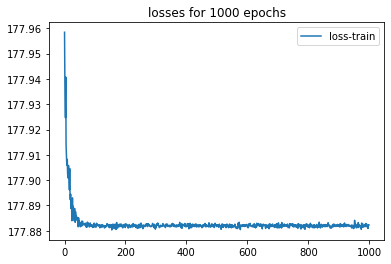

In [20]:
num_topics = 5
t_hidden_size = 100
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "relu"

class TrainArguments:
      def __init__(self, epochs, batch_size, log_interval):
          self.epochs = epochs
          self.batch_size = batch_size
          self.log_interval = log_interval

class OptimizerArguments:
      def __init__(self, optimizer_name, lr, wdecay):
            self.optimizer = optimizer_name
            self.lr = lr
            self.wdecay = wdecay
            
train_args = TrainArguments(epochs=1000, batch_size=6, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.001, wdecay=0.1)

print(train_args.epochs)
print(optimizer_args.optimizer)

training_set = train_set

# define the ETM-model with setting-parameters
etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

# start training
train_class = TrainETM().train(
    etm_model,
    vocab_size, 
    train_args, optimizer_args, training_set) 
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act, embedding_data, 0.5)